In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import models, transforms, datasets
import torch.optim as optim
import os, pickle, time, copy, glob
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import argparse
import json



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:

transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}

trans = ['train_transforms','test_transforms']
path = "/content/gdrive/My Drive/Colab Notebooks/MainData/"
categories = ['train','test']

In [ ]:
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}


In [ ]:
# creating training indices to be used for validation
len_train = len(dset['train'])
print('original train dataset size ', len_train) 
len_test = len(dset['test'])
print('original test dataset size ', len_test) 

indices_list = range(len_train)
indices = [*indices_list]

#Shuffling the list of indices 
np.random.shuffle(indices)
#Splitting the indices based on train and val percentage
split = int(np.floor(0.2 * len_train))
train_idx, valid_idx = indices[split:], indices[:split]
print('Upadted train dataset size:', len(train_idx))
print('Created validation dataset size:', len(valid_idx))
test_idx = [i for i in range(len(dset['test']))]
print('the test imagedataest size', len(dset['test']))

#define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

dataset_sizes = {}
dataset_sizes['train'] = train_sampler.__len__()
dataset_sizes['test'] = test_sampler.__len__()
dataset_sizes['val'] = valid_sampler.__len__()
print(dataset_sizes['val'], dataset_sizes['test'], dataset_sizes['train'])


original train dataset size  2031
original test dataset size  3040
Upadted train dataset size: 1625
Created validation dataset size: 406
the test imagedataest size 3040
406 3040 1625


In [ ]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16,
    drop_last= True, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16, 
    drop_last= True, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(dset['test'], batch_size=16, 
    drop_last= True,sampler=test_sampler,num_workers=0)


In [ ]:
dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}

class_names = dset['train'].classes

In [ ]:
images, labels = next(iter(dataloaders['test']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()]))

label: 0, class: covid-n


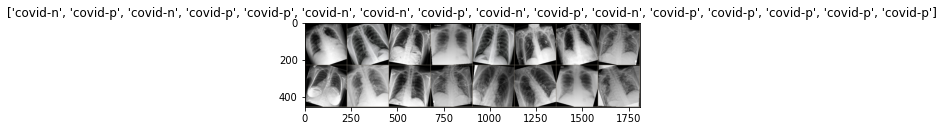

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
inputs,classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)
class_names = dset["train"].classes
imshow(out, title = [class_names[x] for x in classes])


In [ ]:
class ModelAlexnet(nn.Module):
    def __init__(self):
        super(ModelAlexnet, self).__init__()
      
        self.model = torchvision.models.alexnet(pretrained=True)
        
        self.classifier = nn.Sequential(
        nn.Linear(4096,2),
        nn.LogSoftmax(dim=1))
     
        for params in self.model.parameters():
            params.requires_grad = False
            
        self.model.classifier[6] = self.classifier

    def forward(self, x):
        
        return self.model(x)


model = ModelAlexnet()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []
def fit(self, dataloaders, num_epochs):

       
        train_on_gpu = torch.cuda.is_available()
        
        optimizer = optim.Adam(self.model.parameters(), lr=0.01 )
       
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
       
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
     
        if train_on_gpu:
            self.model = self.model.cuda()
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            
            for phase in ['train', 'val']:
       
                if phase == 'train':
                    scheduler.step()
                    self.model.train()  
                else:
                    self.model.eval()   
                running_loss = 0.0
                running_corrects = 0
           
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    
                    optimizer.zero_grad()
                    
                
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                      
                        loss = criterion(outputs, labels)

                       
                        if phase == 'train':
                            
                            loss.backward()
                          
                            optimizer.step()
       
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                if(phase == 'train'):
                  train_losses.append(epoch_loss)   
                  train_acc.append(epoch_acc) 
                if(phase == 'val'):
                  val_losses.append(epoch_loss)   
                  val_acc.append(epoch_acc) 

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
 
        self.model.load_state_dict(best_model_wts)
        return self.model


In [ ]:
num_epochs = 5
model1_alexnet = fit(model, dataloaders, num_epochs)

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4176 Acc: 0.9791
val Loss: 0.1428 Acc: 0.9631
Epoch 1/4
----------
train Loss: 0.1475 Acc: 0.9840
val Loss: 0.0458 Acc: 0.9828
Epoch 2/4
----------
train Loss: 0.0924 Acc: 0.9877
val Loss: 0.0255 Acc: 0.9778
Epoch 3/4
----------
train Loss: 0.1137 Acc: 0.9858
val Loss: 0.0823 Acc: 0.9828
Epoch 4/4
----------
train Loss: 0.0608 Acc: 0.9895
val Loss: 0.0769 Acc: 0.9828
Training complete in 24m 18s
Best val Acc: 0.982759


In [ ]:
model1_alexnet.eval()
torch.save(model1_alexnet, '/content/gdrive/My Drive/Colab Notebooks/alexnet_model1_without_aug.pt')

In [ ]:
num_epochs = 10
model2_alexnet = fit(model, dataloaders, num_epochs)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1558 Acc: 0.9815
val Loss: 0.0504 Acc: 0.9754
Epoch 1/9
----------
train Loss: 0.2169 Acc: 0.9846
val Loss: 0.0265 Acc: 0.9803
Epoch 2/9
----------
train Loss: 0.2174 Acc: 0.9840
val Loss: 0.0819 Acc: 0.9803
Epoch 3/9
----------
train Loss: 0.0797 Acc: 0.9877
val Loss: 0.1624 Acc: 0.9778
Epoch 4/9
----------
train Loss: 0.0680 Acc: 0.9883
val Loss: 0.1425 Acc: 0.9828
Epoch 5/9
----------
train Loss: 0.1138 Acc: 0.9877
val Loss: 0.0087 Acc: 0.9828
Epoch 6/9
----------
train Loss: 0.0888 Acc: 0.9889
val Loss: 0.1028 Acc: 0.9803
Epoch 7/9
----------
train Loss: 0.0607 Acc: 0.9889
val Loss: 0.0342 Acc: 0.9828
Epoch 8/9
----------
train Loss: 0.0574 Acc: 0.9895
val Loss: 0.0424 Acc: 0.9778
Epoch 9/9
----------
train Loss: 0.0883 Acc: 0.9895
val Loss: 0.0017 Acc: 0.9852
Training complete in 2m 45s
Best val Acc: 0.985222


In [ ]:
model2_alexnet.eval()
torch.save(model2_alexnet, '/content/gdrive/My Drive/Colab Notebooks/alexnet_model2_without_aug.pt')

In [ ]:
num_epochs = 15
model3_alexnet = fit(model, dataloaders, num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1772 Acc: 0.9877
val Loss: 0.0006 Acc: 0.9852
Epoch 1/14
----------
train Loss: 0.1659 Acc: 0.9852
val Loss: 0.2395 Acc: 0.9778
Epoch 2/14
----------
train Loss: 0.1977 Acc: 0.9889
val Loss: 0.1499 Acc: 0.9778
Epoch 3/14
----------
train Loss: 0.0945 Acc: 0.9883
val Loss: 0.1502 Acc: 0.9828
Epoch 4/14
----------
train Loss: 0.0300 Acc: 0.9914
val Loss: 0.1379 Acc: 0.9803
Epoch 5/14
----------
train Loss: 0.1078 Acc: 0.9883
val Loss: 0.1005 Acc: 0.9828
Epoch 6/14
----------
train Loss: 0.1107 Acc: 0.9877
val Loss: 0.1439 Acc: 0.9828
Epoch 7/14
----------
train Loss: 0.0757 Acc: 0.9895
val Loss: 0.0860 Acc: 0.9828
Epoch 8/14
----------
train Loss: 0.0731 Acc: 0.9895
val Loss: 0.1159 Acc: 0.9828
Epoch 9/14
----------
train Loss: 0.0631 Acc: 0.9914
val Loss: 0.0014 Acc: 0.9852
Epoch 10/14
----------
train Loss: 0.0698 Acc: 0.9895
val Loss: 0.0810 Acc: 0.9828
Epoch 11/14
----------
train Loss: 0.0832 Acc: 0.9920
val Loss: 0.1224 Acc: 0.9828
Epoch 12/14
----------
train Loss: 0

In [ ]:
model3_alexnet.eval()
torch.save(model3_alexnet, '/content/gdrive/My Drive/Colab Notebooks/alexnet_model3_without_aug.pt')

In [ ]:
num_epochs = 20
model4_alexnet = fit(model, dataloaders, num_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1430 Acc: 0.9871
val Loss: 0.2509 Acc: 0.9778
Epoch 1/19
----------
train Loss: 0.0895 Acc: 0.9902
val Loss: 0.0649 Acc: 0.9828
Epoch 2/19
----------
train Loss: 0.2274 Acc: 0.9852
val Loss: 0.3030 Acc: 0.9680
Epoch 3/19
----------
train Loss: 0.3332 Acc: 0.9809
val Loss: 0.2275 Acc: 0.9803
Epoch 4/19
----------
train Loss: 0.0785 Acc: 0.9902
val Loss: 0.1212 Acc: 0.9828
Epoch 5/19
----------
train Loss: 0.0731 Acc: 0.9902
val Loss: 0.1438 Acc: 0.9828
Epoch 6/19
----------
train Loss: 0.0279 Acc: 0.9920
val Loss: 0.1151 Acc: 0.9803
Epoch 7/19
----------
train Loss: 0.0248 Acc: 0.9920
val Loss: 0.1249 Acc: 0.9803
Epoch 8/19
----------
train Loss: 0.1520 Acc: 0.9908
val Loss: 0.0631 Acc: 0.9803
Epoch 9/19
----------
train Loss: 0.0285 Acc: 0.9926
val Loss: 0.1524 Acc: 0.9828
Epoch 10/19
----------
train Loss: 0.0930 Acc: 0.9889
val Loss: 0.1304 Acc: 0.9828
Epoch 11/19
----------
train Loss: 0.1164 Acc: 0.9902
val Loss: 0.1309 Acc: 0.9803
Epoch 12/19
----------
train Loss: 0

In [ ]:
model4_alexnet.eval()
torch.save(model4_alexnet, '/content/gdrive/My Drive/Colab Notebooks/alexnet_model4_without_aug.pt')

In [ ]:
num_epochs = 25
model5_alexnet = fit(model, dataloaders, num_epochs)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1039 Acc: 0.9895
val Loss: 0.1541 Acc: 0.9803
Epoch 1/24
----------
train Loss: 0.0926 Acc: 0.9914
val Loss: 0.2719 Acc: 0.9778
Epoch 2/24
----------
train Loss: 0.3041 Acc: 0.9858
val Loss: 0.1471 Acc: 0.9828
Epoch 3/24
----------
train Loss: 0.1893 Acc: 0.9914
val Loss: 0.1664 Acc: 0.9803
Epoch 4/24
----------
train Loss: 0.0720 Acc: 0.9889
val Loss: 0.0744 Acc: 0.9803
Epoch 5/24
----------
train Loss: 0.0916 Acc: 0.9895
val Loss: 0.0541 Acc: 0.9828
Epoch 6/24
----------
train Loss: 0.1333 Acc: 0.9883
val Loss: 0.0252 Acc: 0.9828
Epoch 7/24
----------
train Loss: 0.1241 Acc: 0.9902
val Loss: 0.0793 Acc: 0.9803
Epoch 8/24
----------
train Loss: 0.1358 Acc: 0.9889
val Loss: 0.1107 Acc: 0.9828
Epoch 9/24
----------
train Loss: 0.1484 Acc: 0.9883
val Loss: 0.0000 Acc: 0.9852
Epoch 10/24
----------
train Loss: 0.1106 Acc: 0.9877
val Loss: 0.1255 Acc: 0.9828
Epoch 11/24
----------
train Loss: 0.0275 Acc: 0.9920
val Loss: 0.0405 Acc: 0.9828
Epoch 12/24
----------
train Loss: 0

In [ ]:
model5_alexnet.eval()
torch.save(model5_alexnet, '/content/gdrive/My Drive/Colab Notebooks/alexnet_model5_without_aug.pt')